In [0]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
np.random.seed(1244)

In [2]:
#read training data
data = pd.read_csv("train_data.txt")
print(data.head())
trainY = data["Occupancy"].values
data = data.drop(["date", "Occupancy"], axis=1)
trainX = data.values
print(data.shape)

                  date  Temperature  Humidity  ...     CO2  HumidityRatio  Occupancy
1  2015-02-04 17:51:00        23.18   27.2720  ...  721.25       0.004793          1
2  2015-02-04 17:51:59        23.15   27.2675  ...  714.00       0.004783          1
3  2015-02-04 17:53:00        23.15   27.2450  ...  713.50       0.004779          1
4  2015-02-04 17:54:00        23.15   27.2000  ...  708.25       0.004772          1
5  2015-02-04 17:55:00        23.10   27.2000  ...  704.50       0.004757          1

[5 rows x 7 columns]
(8143, 5)


In [3]:
#read test data
testX = pd.read_csv("test_data.txt")
testY = testX["Occupancy"].values
testX = testX.drop(["date", "Occupancy"], axis=1)
testX = torch.Tensor(testX.values)
print(testX.shape)

torch.Size([9752, 5])


In [0]:
# function to make batches
def makeBatch(data, labels, batchSize):
    N = int(data.shape[0]/batchSize)
    X = []
    Y = []
    #slicing original list to creating batch
    for i in range(N):
        X.append(torch.Tensor(data[i*batchSize:(i+1)*batchSize]))
        Y.append(torch.Tensor(labels[i*batchSize:(i+1)*batchSize]).reshape(-1,1))
    
    #create a new batch of remaining elements
    if data.shape[0]%batchSize != 0:
        X.append(torch.Tensor(data[N*batchSize:]))
        Y.append(torch.Tensor(labels[N*batchSize:]).reshape(-1,1))
    return X, Y

In [0]:
#function to compute baseline performance
def baseline(testX, testY):
    correct = 0
    for y in testY:
        prediction = 0
        for i in range(5):
          prediction += np.random.randint(2)
        if prediction < 3 and y == 0:
            correct += 1
        elif prediction >= 3 and y == 1:
            correct += 1
            
    print("Baseline Performance: ", correct/len(testY))
    return 1-correct/len(testY)

In [0]:
#function to test the model
#plotevery flag is used to return training error
#ret flag is used to return testing accuracy
def test(model, loss_fn, X, Y, plotEvery=False, ret=False):
    with torch.no_grad():
        model.eval()
        y_pred = model(X)
        
    #computing accuracy
    correct = 0
    for i in range(len(y_pred)):
        if y_pred[i] >= 0.5 and Y[i] == 1:
            correct += 1
        elif y_pred[i] < 0.5 and Y[i] == 0:
            correct += 1
            
    if plotEvery:
        return 1.0-correct/len(Y)
    if ret:
        return correct/len(Y)
    print("Accuracy: ", correct/len(Y))

In [0]:
#function to train the model
def learn(model, loss_fn, optimizer, X, Y, epoch, dataX=[], dataY=[], baseError=0.5, plotEvery=False):
    trainError = []
    dataX = torch.Tensor(dataX)
    dataY = torch.Tensor(dataY).view(-1,1)
    iter = 0
    #do it for every epoch
    for i in range(epoch):
        training_loss = 0.0
        model.train()
        #do it for every batch
        for j in range(len(X)):
            x = X[j]
            y = Y[j]
            y_pred = model(x)
            #compute loss
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
        if i == epoch-1:
            print(i+1, "th epoch Loss:",training_loss/len(X)) 
            
        #plotting training error every 20th epoch
        if plotEvery and i%20 == 19: 
            iter += 1
            trainError.append(test(model, loss_fn, dataX, dataY, True))
        
    #plotting training error
    if plotEvery == True:
        X = np.arange(1, iter+1)*20
        baseY = [baseError]*iter
        plt.plot(X, trainError, color='red', label="Training")
        plt.plot(X, baseY, color='blue', label="Baseline")
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.legend()
        plt.show()
        
            
    return model

###Answer to all the parts(a-f) of 3rd question are shown in the output cell

### Note: We used 1 neuron in output layer because we are instructed in the question to do so. The results are quite sensitive to weight initialisations. The outputs and graphs of a-f are given in next output cell. part g is answered in last 2 ouput cells.<br>
<h4>a) The architecture consists of a 100 neuron hidden layer. The training accuracy is 0.95 and testing accuracy is 0.94.
<br><br>
b) The baseline error is 0.505.
<br><br>
c) We can verify from the graph that eventually falls below the baseline error. The training accuracy is 0.93 and testing accuracy is 0.94.
<br><br>
d) On using batch gradient descent we observe a decrease in both training and testing accuracies. Both the accuracies fall to 78%. When we learn over entire dataset the gradients gets averaged and randomness reduces. This exposes the model to being stuck in a local minima. Mini-batches don't suffer this disadvantage and hence this explains the results.
<br><br>
e) We have used Adam optimizer it adapts the learning rate accordingly. It is observed that hidden layer with 1 neuron performs worst followed by 5 neurons. Performance is nearly same for architecture of 10 and 20 neurons.
<br><br>
f) BCELoss is supposed to work better for classification problems while MSELoss is supposed to work better for regression problems. Same can be reaffirmed by our observation from mini-batch SGD results. With BCELoss training and testing accuracies are above 90% and with MSELoss it falls around 80%. We conclude that MSELoss penalizes error badly and hurts the model. Similar trend can be in case of number of neurons vs accuracy graph.
<br><br>
g) Following are the architectures we tried:<br>
i)  First hidden layer 60 neurons, second hidden layer 10 neurons.<br> 
ii) first hidden layer 60 neurons, second hidden layer 10 neurons.<br>
Both of them perform with an accuracy of a little above 94%. This is nearly same to the architecture given in part a. We conclude that the model becomes more  complex and overfits on the training data.</h4>


A) 
1000 th epoch Loss: 0.1062175254854891
Train Accuracy:  0.9554218347046542
Test Accuracy:  0.9470877768662839



B) 
Baseline Performance:  0.5052296964725185



C) 
500 th epoch Loss: 0.18657878027638283


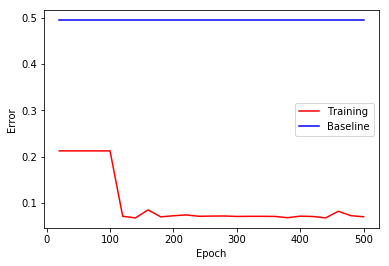

Train Accuracy:  0.9301240329117033
Test Accuracy:  0.940422477440525



D) 
500 th epoch Loss: 0.6334252953529358


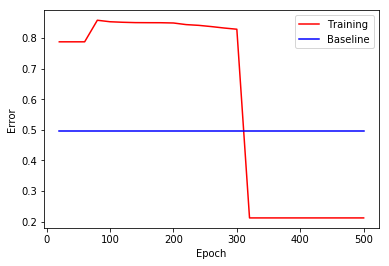

Train Accuracy:  0.7876703917475132
Test Accuracy:  0.7898892534864643



E) 
500 th epoch Loss: 0.5375909705956777
500 th epoch Loss: 0.08096265689366394
500 th epoch Loss: 0.12420120379991001
500 th epoch Loss: 0.09246534357468288
500 th epoch Loss: 0.06711751564095418


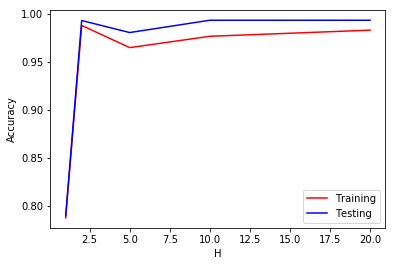

F) doing C again
500 th epoch Loss: 0.17039914951637025


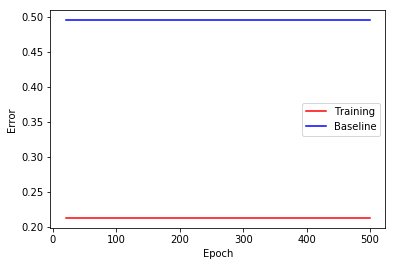

Train Accuracy:  0.7876703917475132
Test Accuracy:  0.7898892534864643



F) doing C again
500 th epoch Loss: 0.1701621413230896


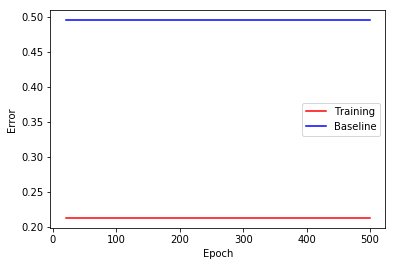

Train Accuracy:  0.7876703917475132
Test Accuracy:  0.7898892534864643



F) doing C again
500 th epoch Loss: 0.17638144973251554
500 th epoch Loss: 0.016409302906443674
500 th epoch Loss: 0.02994543044931359
500 th epoch Loss: 0.02195744226790137
500 th epoch Loss: 0.017007018594692152


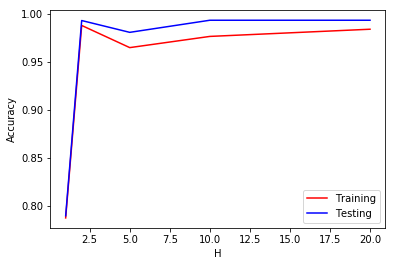

In [36]:
#Answer to part 3) a)
print("A) ")
model = torch.nn.Sequential(
    torch.nn.Linear(5, 100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(100, 1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
X, Y = makeBatch(trainX, trainY, 1000)
model = learn(model, loss_fn, optimizer, X, Y, 1000)
print("Train ", end="")
test(model, loss_fn, torch.Tensor(trainX), torch.Tensor(trainY))
print("Test ", end="")
test(model, loss_fn, testX, testY)
print("\n\n")

#Answer to part 3) b) 
print("B) ")
baseError = baseline(testX, testY)
print("\n\n")

for flag in range(2):
    if(flag == 0):
        loss_fn = torch.nn.BCELoss()
    else:
        loss_fn = torch.nn.MSELoss()

    #Answer to part 3) c)
    if(flag == 0):
        print("C) ")
    else:
        print("F) doing C again")
    model = torch.nn.Sequential(
        torch.nn.Linear(5, 5),
        torch.nn.Sigmoid(),
        torch.nn.Linear(5, 1),
        torch.nn.Sigmoid()
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    X, Y = makeBatch(trainX, trainY, 100)
    model = learn(model, loss_fn, optimizer, X, Y, 500, trainX, trainY, baseError, True)
    print("Train ", end="")
    test(model, loss_fn, torch.Tensor(trainX), torch.Tensor(trainY))
    print("Test ", end="")
    test(model, loss_fn, testX, testY)
    print("\n\n")

    #Answer to part 3) d)
    if(flag == 0):
        print("D) ")
    else:
        print("F) doing C again")
    model = torch.nn.Sequential(
        torch.nn.Linear(5, 5),
        torch.nn.Sigmoid(),
        torch.nn.Linear(5, 1),
        torch.nn.Sigmoid()
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    X, Y = makeBatch(trainX, trainY, len(trainX))
    model = learn(model, loss_fn, optimizer, X, Y, 500, trainX, trainY, baseError, True)
    print("Train ", end="")
    test(model, loss_fn, torch.Tensor(trainX), torch.Tensor(trainY))
    print("Test ", end="")
    test(model, loss_fn, testX, testY)
    print("\n\n")

#     Answer to part 3) e)
    if(flag == 0):
        print("E) ")
    else:
        print("F) doing C again")
    H = [1, 2, 5, 10, 20]
    testAcc = []
    trainAcc = []
    for h in H:
        model = torch.nn.Sequential(
            torch.nn.Linear(5, h),
            torch.nn.Sigmoid(),
            torch.nn.Linear(h, 1),
            torch.nn.Sigmoid()
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        X, Y = makeBatch(trainX, trainY, 1000)
        model = learn(model, loss_fn, optimizer, X, Y, 500)
        testAcc.append(test(model, loss_fn, testX, testY, ret=True))
        trainAcc.append(test(model, loss_fn, torch.Tensor(trainX), torch.Tensor(trainY), ret=True))


    plt.plot(H, trainAcc, color='red', label="Training")
    plt.plot(H, testAcc, color='blue', label="Testing")
    plt.xlabel("H")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Answer to 3) g)

In [9]:
print("G) ")
model = torch.nn.Sequential(
    torch.nn.Linear(5, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
X, Y = makeBatch(trainX, trainY, len(trainX))
model = learn(model, loss_fn, optimizer, X, Y, 500)
print("\n\n")
print("Train ", end="")
test(model, loss_fn, torch.Tensor(trainX), torch.Tensor(trainY))
print("Test ", end="")
test(model, loss_fn, testX, testY)

G) 
500 th epoch Loss: 0.1310526579618454



Train Accuracy:  0.9319661058577919
Test Accuracy:  0.940935192780968


In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(5, 60),
    torch.nn.ReLU(),
    torch.nn.Linear(60, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
X, Y = makeBatch(trainX, trainY, len(trainX))
model = learn(model, loss_fn, optimizer, X, Y, 500)
print("\n\n")
print("Train ", end="")
test(model, loss_fn, torch.Tensor(trainX), torch.Tensor(trainY))
print("Test ", end="")
test(model, loss_fn, testX, testY)

500 th epoch Loss: 0.12553507089614868



Train Accuracy:  0.9303696426378485
Test Accuracy:  0.9410377358490566
